In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import os
%matplotlib inline

In [2]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [3]:
#os.chdir(r"'data/singleuseranalysis")
#df = pd.read_table('dfchangepoint.csv', sep=',')
df = pd.read_csv('data/dfchangepoint.csv', encoding='utf-8')

In [4]:
df.head()

,lat,long,date,time,userid,date_time,Transportation_Mode,col,row,time_delta,...,segmentid,Vincenty_distance,velocity,acceleration,velocity_rate,jerk,acc_rate,bearing,bearing_rate,rate_bearing_rate
0,39.979547,116.306813,2011-08-29,10:13:15,141.0,2011-08-29 10:13:15,walk,6.0,11.0,1.0,...,1.0,1.551677,1.551677,0.550164,0.354561,-1.017630,-1.849685,33.297150,-5.088421,14.341677
1,39.991755,116.309247,2011-09-02,11:00:06,141.0,2011-09-02 11:00:06,subway,6.0,12.0,1.0,...,2.0,0.936172,0.936172,-0.010884,-0.011626,-0.174173,16.002351,171.288476,8.711524,-8.711524
2,39.976225,116.337132,2011-09-02,11:23:44,141.0,2011-09-02 11:23:44,subway,7.0,11.0,1.0,...,1.0,10.396209,10.396209,-9.930727,-0.955226,10.943352,-1.101969,33.111536,33.380151,-251.177107
3,39.975575,116.336827,2011-09-02,11:24:48,141.0,2011-09-02 11:24:48,walk,7.0,11.0,1.0,...,2.0,0.573136,0.573136,0.127325,0.222156,-0.262618,-2.062574,165.670813,-23.134427,11.620013
4,39.975452,116.337508,2011-09-02,12:11:01,141.0,2011-09-02 12:11:01,walk,7.0,11.0,1.0,...,1.0,1.471056,1.471056,3.431064,2.332382,-1.999719,-0.582828,104.627203,-224.114180,219.775017


In [45]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['lat', 'long'])

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 0.5 / kms_per_radian

In [63]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=8, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 79 points down to 4 clusters, for 94.9% compression in 0.00 seconds
Silhouette coefficient: 0.441


In [50]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [69]:
coords[cluster_labels==1]

array([[ 39.99133333, 116.33181667],
       [ 39.99132   , 116.32814667],
       [ 39.99104833, 116.32698   ],
       [ 39.99169   , 116.3337    ],
       [ 39.99183167, 116.33007333],
       [ 39.99130167, 116.328885  ],
       [ 39.99039667, 116.33073833],
       [ 39.99149167, 116.33149   ]])

In [51]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

IndexError: list index out of range

In [37]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lat,lon
0,39.977678,116.327168
1,39.998605,116.386002
2,39.919478,116.351400
3,39.991343,116.196833


In [38]:
#rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['long']==row['long'])].iloc[0], axis=1)
#rs.tail()

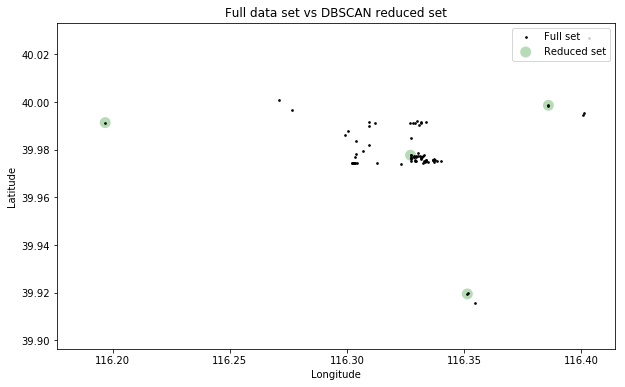

In [39]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['long'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [11]:
len(rep_points)

6